<Axes: title={'center': 'Category Count'}, xlabel='Category'>

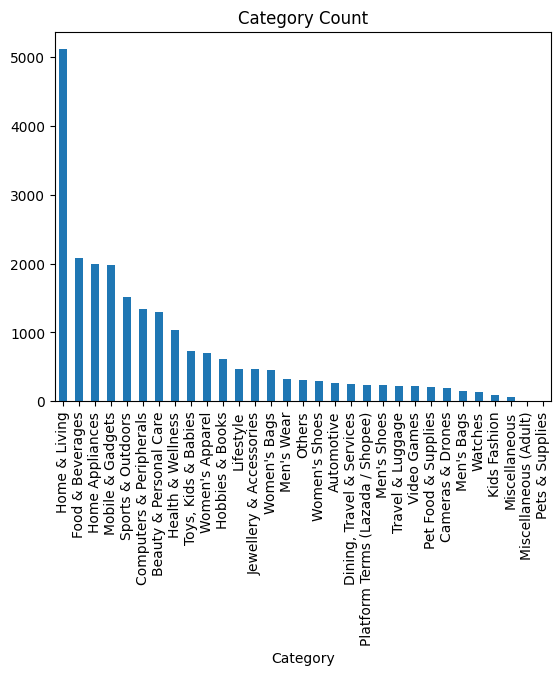

In [3]:
import pickle
from pandas import DataFrame

with open('./data/excel.pkl', 'rb') as f:
    excel = pickle.load(f)

country = 'SG'
# dataframe 包含 Keyword, Category 列
data = excel[country].drop_duplicates(
    subset=['Keyword'], keep='first').reset_index(drop=True)  # type: ignore

# 分类各个 Category 的数量
category_count = data['Category'].value_counts()
# 绘制为柱状图
category_count.plot(kind='bar', title='Category Count')

# 绘制饼图
# category_count.plot(kind='pie', title='Category Count', autopct='%1.1f%%')

<Axes: title={'center': 'Test Category Count'}, ylabel='count'>

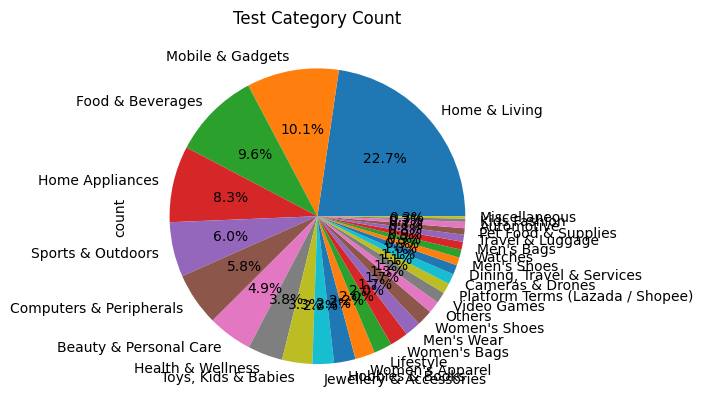

In [5]:
import pickle
from pandas import DataFrame
from sklearn.model_selection import train_test_split

with open('./data/excel.pkl', 'rb') as f:
    excel = pickle.load(f)

country = 'SG'
# dataframe 包含 Keyword, Category 列
data = excel[country].drop_duplicates(
    subset=['Keyword'], keep='first').reset_index(drop=True)  # type: ignore

X = data["Keyword"]
y = data["Category"]

# 使用 train_test_split 将数据划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X.tolist(), y.tolist(), test_size=0.05, random_state=0)

train_df = DataFrame({'Keyword': X_train, 'Category': y_train})
test_df = DataFrame({'Keyword': X_test, 'Category': y_test})

# 分类各个 Category 的数量
train_category_count = train_df['Category'].value_counts()
test_category_count = test_df['Category'].value_counts()

# 绘制为柱状图
# train_category_count.plot(kind='bar', title='Train Category Count')
# test_category_count.plot(kind='bar', title='Test Category Count')

# 绘制饼图
# train_category_count.plot(
#     kind='pie', title='Train Category Count', autopct='%1.1f%%')
test_category_count.plot(
    kind='pie', title='Test Category Count', autopct='%1.1f%%')

In [1]:
"""
分词训练集和测试集词汇表差异
"""


def read_vocab(vocab_path):
    with open(vocab_path, 'r') as f:
        return f.readlines()


def write_vocab(vocab_path, words):
    with open(vocab_path, 'w') as f:
        f.writelines(words)


# 分析训练集和测试集的分词结果的差异
country = 'SG'
train_vocab_path = f'./vocab/{country}/train_vocab.txt'
test_vocab_path = f'./vocab/{country}/test_vocab.txt'

train_words = read_vocab(train_vocab_path)
test_words = read_vocab(test_vocab_path)
train_words, test_words = set(train_words), set(test_words)
print(f'训练集词汇量: {len(train_words)}')
print(f'测试集词汇量: {len(test_words)}')
print(f'测试集和训练集词汇量差异: {len(test_words - train_words)}')
print(f'测试集和训练集词汇量差异: {(test_words - train_words)}')
write_vocab(f'./vocab/{country}/test_train_diff_vocab.txt',
            test_words - train_words)

训练集词汇量: 9867
测试集词汇量: 1490
测试集和训练集词汇量差异: 271
测试集和训练集词汇量差异: {'evadict\n', '10lb\n', 'lorna\n', 'vento\n', 'sara\n', '288mail\n', 'torpedo\n', 'jade\n', 'k6\n', 'c55\n', '足贴\n', 'lindberg\n', 'bonia\n', 'fyre\n', 'cauliflower\n', 'osakakuma\n', 'bcw\n', 'waterdrop\n', 'disinfection\n', 'select\n', '5i\n', 'ashwagandha\n', 'skinzen\n', 'ashtray\n', 'daster\n', 'allstar\n', 'cro\n', 'beacon1\n', 'muslim\n', 'thermaltake\n', 'primal\n', 'ichiyo\n', 'mf11\n', 'wei\n', 'shahi\n', 'vernici\n', 'lapel\n', 'puncher\n', 'supermarkt\n', 'utd\n', 'locksmith\n', 'mori\n', 'sgfishingrigz\n', 'ollella\n', 'meixin\n', 'kosas\n', 'amazon.sg\n', 'dage\n', 'coq\n', 'note12\n', 'pixiu\n', 'sugru\n', '老\n', 'epsom\n', 'dig\n', 'vibrant\n', 'showy\n', 'semi\n', 'sheridan\n', 'p2o\n', 'liter\n', 'rog3\n', 'oem\n', 'separator\n', 'azanis\n', 'tf\n', 'golfshoe\n', 'merida\n', '青龙\n', 'fragrancecart\n', 'fixer\n', 'psp\n', 'bossipaw\n', 'moc\n', 'crossing\n', 'motivation\n', 's15\n', 'agility\n', 'garage\n', 'rad

In [5]:
import torch

a = torch.tensor([1, 2, 3])
a.unsqueeze(0).shape

torch.Size([1, 3])

In [15]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import time
import datetime
import os

# 1. 读取数据
data = pd.read_csv('./data/csv/sg.csv')

# 2. 标签编码
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['Category'])

# 3. 初始化分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 6


def encode_keywords(keywords, tokenizer, max_len):
    return tokenizer.encode_plus(
        keywords,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
    )


# 5. 应用编码
encoded_data = data['Keyword'].apply(
    lambda x: encode_keywords(x, tokenizer, MAX_LEN))

input_ids = torch.stack([item['input_ids'].squeeze() for item in encoded_data])
attention_masks = torch.stack(
    [item['attention_mask'].squeeze() for item in encoded_data])
labels = torch.tensor(data['label'].values)

# 6. 划分数据集
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_masks, labels, test_size=0.1, random_state=42
)

train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    train_inputs, train_masks, train_labels, test_size=0.1, random_state=42
)

# 7. 创建 TensorDataset
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

# 8. 创建 DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=BATCH_SIZE
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=BATCH_SIZE
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=BATCH_SIZE
)

# 9. 初始化模型
model = BertForSequenceClassification.from_pretrained(
    os.path.abspath('./model_save/'),
    num_labels=31,
    output_attentions=False,
    output_hidden_states=False
)
device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)  # type: ignore

for step, batch in enumerate(train_dataloader):
    model.train()

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
    break

In [4]:
import pandas as pd

data = pd.read_csv('./data/csv/sg.csv')
data[['Keyword', 'Category']].describe()

,Keyword,Category
count,24683,24683
unique,23011,31
top,3060,Home & Living
freq,25,5392


In [8]:
# data[['Keyword', 'Category']].info()

# 假设 df 是我们的数据集，"category_feature" 是类别特征，"label" 是标签列
cross_tab = pd.crosstab(data['imp_level1_category_1d'], data['Category'])
print(cross_tab)

Category                      Automotive  Beauty & Personal Care  \
imp_level1_category_1d                                             
-                                      0                       0   
Audio                                  0                       0   
Automobiles                           16                       0   
Automotive                           181                       1   
Baby & Kids Fashion                    1                       0   
Beauty                                 0                     120   
Beauty & Personal Care                 2                     883   
Books & Magazines                      0                       2   
Cameras & Drones                       1                       0   
Computers & Accessories                1                       0   
Computers & Peripherals                0                       1   
Dining, Travel & Services              0                       0   
Fashion Accessories                    0        

In [9]:
grouped = data.groupby(['imp_level1_category_1d', 'Category']
                       ).size().unstack(fill_value=0)
print(grouped)

Category                      Automotive  Beauty & Personal Care  \
imp_level1_category_1d                                             
-                                      0                       0   
Audio                                  0                       0   
Automobiles                           16                       0   
Automotive                           181                       1   
Baby & Kids Fashion                    1                       0   
Beauty                                 0                     120   
Beauty & Personal Care                 2                     883   
Books & Magazines                      0                       2   
Cameras & Drones                       1                       0   
Computers & Accessories                1                       0   
Computers & Peripherals                0                       1   
Dining, Travel & Services              0                       0   
Fashion Accessories                    0        

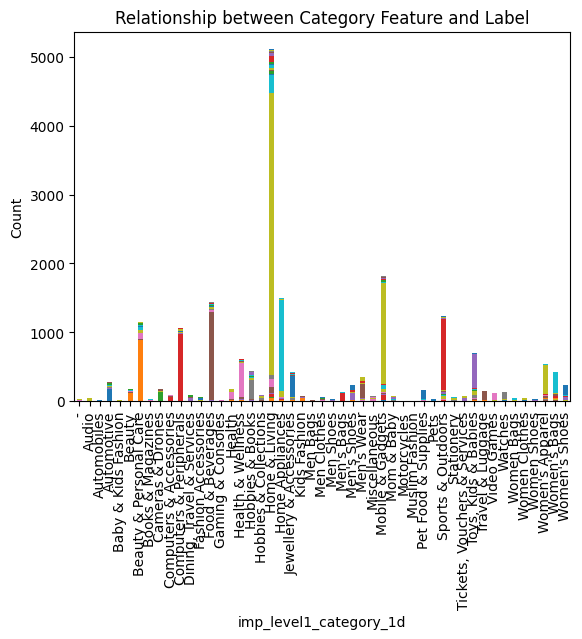

In [15]:
import matplotlib.pyplot as plt

cross_tab = pd.crosstab(data['imp_level1_category_1d'], data['Category'])
# print(cross_tab)

cross_tab.plot(kind='bar', stacked=True)
plt.xlabel('imp_level1_category_1d')
plt.ylabel('Count')
plt.title('Relationship between Category Feature and Label')
# plt.show()
# 隐藏 legend
plt.legend().set_visible(False)

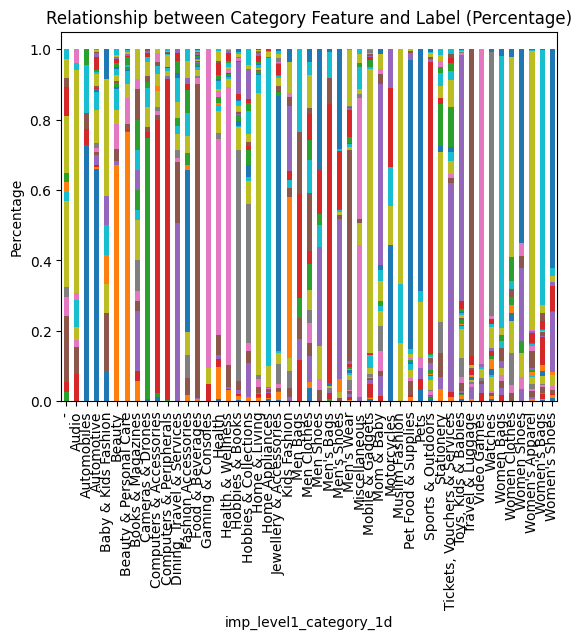

In [17]:
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0)
cross_tab_pct.plot(kind='bar', stacked=True)
plt.xlabel('imp_level1_category_1d')
plt.ylabel('Percentage')
plt.title('Relationship between Category Feature and Label (Percentage)')
plt.legend().set_visible(False)
plt.show()

In [18]:
from scipy.stats import chi2_contingency

# 创建交叉表
contingency_table = pd.crosstab(
    data['imp_level1_category_1d'], data['Category'])

# 执行卡方检验
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 260474.85775769482
p-value: 0.0


In [ ]:
# 分析 shopee 商城 category 和 seo category 的差异
import pandas as pd
import json

df_shopee = pd.read_csv('./data/shopee_sg/keyword_category.csv')
df_seo = pd.read_csv('./data/csv/sg.csv')

df_shopee_category = set(df_shopee['fe_category_1'].unique().tolist())
df_seo_category = set(df_seo['Category'].unique().tolist())

same_category = df_seo_category & df_shopee_category
label_to_index = {}
for index, category in enumerate(same_category):
    label_to_index[category] = index

with open('./config/SG_label_to_index.json', 'w') as f:
    json.dump(label_to_index, f, indent=4)

/tmp/ipykernel_1889/80499493.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_shopee = pd.read_csv('./data/shopee_sg/keyword_category.csv')


<Axes: ylabel='Frequency'>

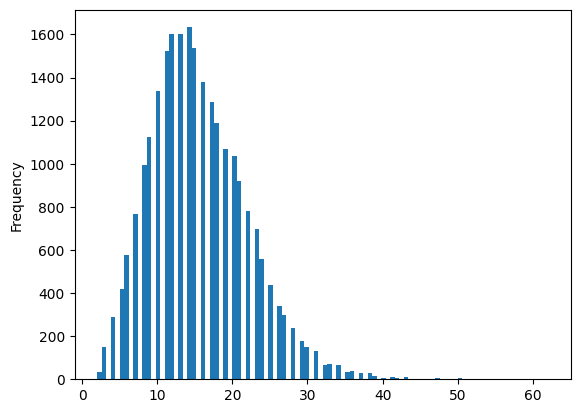

In [3]:
import pandas as pd

data = pd.read_csv('./data/csv/sg.csv')
data['keyword_length'] = data['Keyword'].apply(lambda x: len(x))
# 绘制 keyword_length 的直方图
data['keyword_length'].plot(kind='hist', bins=100)

In [ ]:
import pandas as pd
import json
label2index = json.load(open('./config/SG_label_to_index.json'))

data = pd.read_csv('./data/csv/sg.csv')
new_label2index = {}
for name, count in data['Category'].value_counts().items():
    if name in label2index:
        new_label2index[name] = len(new_label2index)

# 按照降序排列
print(new_label2index)
with open('./config/SG_label_to_index.json', 'w') as f:
    json.dump(new_label2index, f, indent=4)

{'Home & Living': 0, 'Food & Beverages': 1, 'Home Appliances': 2, 'Mobile & Gadgets': 3, 'Sports & Outdoors': 4, 'Computers & Peripherals': 5, 'Beauty & Personal Care': 6, 'Health & Wellness': 7, 'Toys, Kids & Babies': 8, "Women's Apparel": 9, 'Hobbies & Books': 10, "Women's Bags": 11, 'Jewellery & Accessories': 12, "Men's Wear": 13, "Women's Shoes": 14, 'Dining, Travel & Services': 15, 'Automotive': 16, 'Travel & Luggage': 17, "Men's Shoes": 18, 'Video Games': 19, 'Pet Food & Supplies': 20, 'Cameras & Drones': 21, "Men's Bags": 22, 'Watches': 23, 'Kids Fashion': 24, 'Miscellaneous': 25}
